In [1]:
import pandas as pd
import pickle as pk
import matplotlib.pyplot as plt
import itertools as it
import networkx as nx
from collections import (defaultdict,Counter)

In [2]:
#Let's import the chemical-gene interactions from CTD (downloaded on 5th April 2021)
chem_gene_df = pd.read_csv("input/CTD/CTD_chem_gene_ixns.tsv",delimiter= '\t', skipinitialspace=True)
#Here, we filter for only the interactions that regards the H. Sapiens
chem_homo = chem_gene_df[(chem_gene_df['Organism'] == 'Homo sapiens')]

In [3]:
#This cells create a dictionary where each key is a chemical compound and the correspondent value is a genelist 
chem_gene = {}
for i,v in chem_homo.iterrows():
    try:
        chem_gene[v["ChemicalID"]] |= {v["GeneSymbol"]}
    except KeyError as e:
        chem_gene[v["ChemicalID"]] = set([v["GeneSymbol"]])

In [4]:
#Here, we keep only the exposures which perturb at least one gene
chem_gene_cleaned = {}
tot_gene_list=[]
for k,v in chem_gene.items():
    if len(v)>0:
        chem_gene_cleaned[k]=v
        for gene in v:
            tot_gene_list.append(gene)
    else:
        pass


In [5]:
#Let's import the EEN backbone network
final_backbone_exp_graph_significant_combo_df = pd.read_csv("output/final_backbone_exp_graph_significant_combo_ji_df.tsv", sep="\t",index_col=0)
backbone_ss_exposure_network = nx.from_pandas_edgelist(final_backbone_exp_graph_significant_combo_df, 'Exp A', 'Exp B')


In [6]:
#Let's import the resnik score
with open('intermediate/parenthood_similarity_score_pairs_dictio.pickle', 'rb') as handle:
    parenthood_similarity_score_pairs_dictio = pk.load(handle)
with open('intermediate/wo_parentalhood_resnik.pickle', 'rb') as handle:
    wo_parenthood_similarity_score_pairs_dictio = pk.load(handle)

In [7]:
#Let's merge the resnik score without and with parenthood relationships
tot_resnik={**wo_parenthood_similarity_score_pairs_dictio, **parenthood_similarity_score_pairs_dictio}

In [10]:
#Let's import the genetic overlap JI
    
with open('intermediate/parenthood_overlap_pairs_dictio.pickle', 'rb') as handle:
    parenthood_overlap_pairs_dictio = pk.load(handle)
    
with open('intermediate/wo_parentalhood_gene_overlap.pickle', 'rb') as handle:
    wo_parenthood_overlap_pairs_dictio = pk.load(handle)

    

In [11]:
#Let's merge them together

tot_overlap={**wo_parenthood_overlap_pairs_dictio, **parenthood_overlap_pairs_dictio}

In [12]:
tot_overlap_list=[]
tot_resnik_list=[]
for pair,val in tot_overlap.items():
    tot_overlap_list.append(val)
    tot_resnik_list.append(tot_resnik[pair])

In [10]:
import scipy  
from scipy import stats
print(scipy.stats.pearsonr(tot_overlap_list,tot_resnik_list))  # Pearson's r
print(scipy.stats.spearmanr(tot_overlap_list,tot_resnik_list)) # Spearman's rho

(0.027833858604674765, 0.0)
SpearmanrResult(correlation=0.00525483420932538, pvalue=1.9592914717796376e-295)


<ipython-input-7-1df511850d0d>:31: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig('output/Figures/Figure2Cv7.pdf',format='pdf',dpi=300, bbox_inches = "tight")
<ipython-input-7-1df511850d0d>:31: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig('output/Figures/Figure2Cv7.pdf',format='pdf',dpi=300, bbox_inches = "tight")
/Users/lsd/opt/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


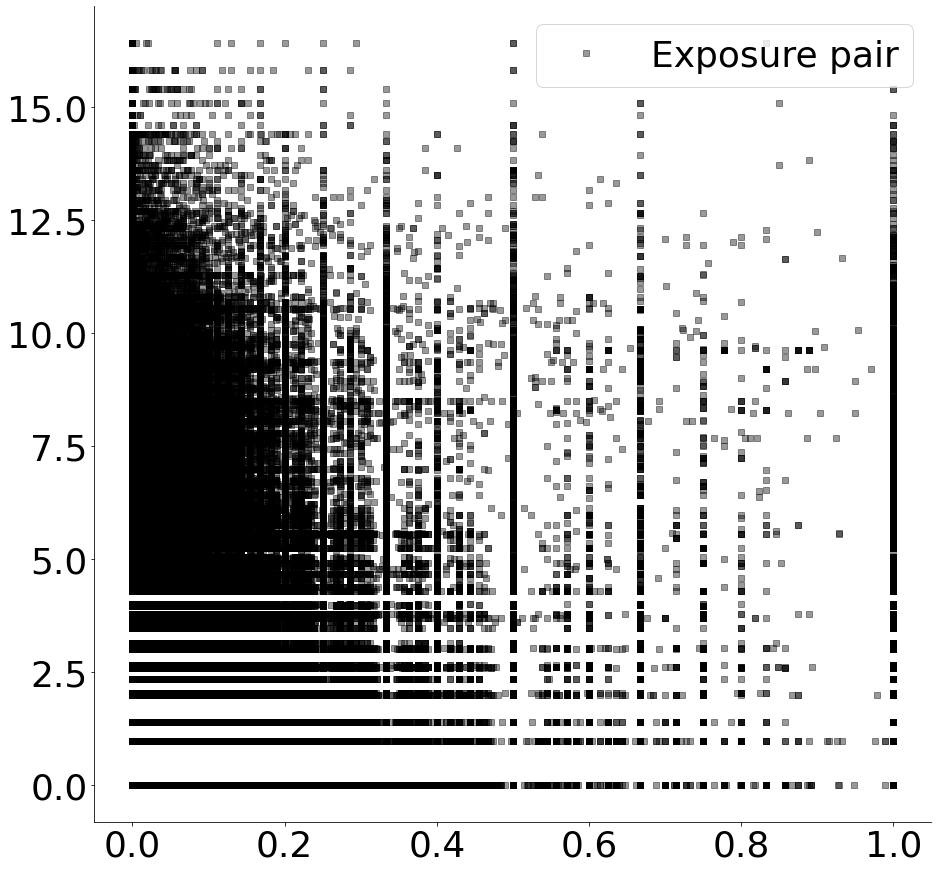

In [7]:
#Correlation coefficient between JI and Resnik score considering all exposures
from matplotlib.pyplot import figure
import scipy  
from scipy import stats
fig, ax = plt.subplots(figsize=(15,15))

slope, intercept, r, p, stderr = scipy.stats.linregress(tot_overlap_list, tot_resnik_list)

ax.plot(tot_overlap_list,tot_resnik_list, linewidth=0, marker='s', c='k',label='Exposure pair', alpha=0.4)
#y=[]
#for i in tot_overlap_list:
#    g=(intercept + slope * i)
#    y.append(g)
#line = "Regression line" 
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
#ax.plot(tot_overlap_list, y, label=line,linewidth=5)
plt.xticks(fontsize=36) 
plt.yticks(fontsize=36) 
#plt.title('Total correlation between Resnik and Genetic overlap' )
ax.legend(facecolor='white',fontsize=36)
import matplotlib
matplotlib.pyplot.rcParams.update({
    "pgf.preamble": [
         "\\usepackage{arev}",
        "\\usepackage[T1]{fontenc}"]
})

plt.savefig('output/Figures/SF4B.pdf',format='pdf',dpi=300, bbox_inches = "tight")

#plt.savefig('output/Figures/SF4B.png',format='png',dpi=300, bbox_inches = "tight")
#plt.show()

In [15]:
#Let's import the Louvain communities

with open('output/Communities/Louvain/ji_fine_grained_communities_dict.pickle', 'rb') as handle:
    fine_grained_communities_dict = pk.load(handle)
with open('output/Communities/Louvain/ji_middle_communities_dict.pickle', 'rb') as handle:
    middle_communities_dict = pk.load(handle)
with open('output/Communities/Louvain/ji_broad_communities_dict.pickle', 'rb') as handle:
    broad_communities_dict = pk.load(handle)
    


In [17]:
#Here, we are evaluating the resnik score across exposures for the finest level of hierarchy in louvain
#distinguishing the exposures that are part of the same community and those ones that are not part
fine_grained_communities_resnik={}

for com,exp_list in fine_grained_communities_dict.items():
    try:
        if len(exp_list)>1:
            resnik_list_in=[]
            resnik_list_out=[]
            pairwise_list = list(it.combinations(exp_list, 2))
            for i in range(len(pairwise_list)):
                try:
                    try:
                        resnik_list_in.append(tot_resnik[pairwise_list[i][0],pairwise_list[i][1]])
                    except:
                        resnik_list_in.append(tot_resnik[pairwise_list[i][1],pairwise_list[i][0]])
                except:
                    pass
            not_exp_com_list=[]
            for exp in backbone_ss_exposure_network.nodes():
                if exp not in exp_list:
                    not_exp_com_list.append(exp)
                else:
                    pass
            for exp1 in exp_list:
                for exp2 in not_exp_com_list:
                    try:
                        try:
                            resnik_list_out.append(tot_resnik[exp1,exp2])
                        except:
                            resnik_list_out.append(tot_resnik[exp2,exp1])
                    except:
                        pass
            avg_resnik_in=sum(resnik_list_in)/len(resnik_list_in)
            avg_resnik_out=sum(resnik_list_out)/len(resnik_list_out)
            fine_grained_communities_resnik[com]=[avg_resnik_in,avg_resnik_out]
        else:
            pass
    except:
        pass


            
middle_communities_resnik={}

for com,exp_list in middle_communities_dict.items():
    try:
        if len(exp_list)>1:
            resnik_list_in=[]
            resnik_list_out=[]
            pairwise_list = list(it.combinations(exp_list, 2))
            for i in range(len(pairwise_list)):
                try:
                    try:
                        resnik_list_in.append(tot_resnik[pairwise_list[i][0],pairwise_list[i][1]])
                    except:
                        resnik_list_in.append(tot_resnik[pairwise_list[i][1],pairwise_list[i][0]])
                except:
                    pass
            not_exp_com_list=[]
            for exp in backbone_ss_exposure_network.nodes():
                if exp not in exp_list:
                    not_exp_com_list.append(exp)
                else:
                    pass
            for exp1 in exp_list:
                for exp2 in not_exp_com_list:
                    try:
                        try:
                            resnik_list_out.append(tot_resnik[exp1,exp2])
                        except:
                            resnik_list_out.append(tot_resnik[exp2,exp1])
                    except:
                        pass
            avg_resnik_in=sum(resnik_list_in)/len(resnik_list_in)
            avg_resnik_out=sum(resnik_list_out)/len(resnik_list_out)
            middle_communities_resnik[com]=[avg_resnik_in,avg_resnik_out]
        else:
            pass
    except:
        pass


broad_communities_resnik={}

for com,exp_list in broad_communities_dict.items():
    try:
        if len(exp_list)>1:
            resnik_list_in=[]
            resnik_list_out=[]
            pairwise_list = list(it.combinations(exp_list, 2))
            for i in range(len(pairwise_list)):
                try:
                    try:
                        resnik_list_in.append(tot_resnik[pairwise_list[i][0],pairwise_list[i][1]])
                    except:
                        resnik_list_in.append(tot_resnik[pairwise_list[i][1],pairwise_list[i][0]])
                except:
                    pass
            not_exp_com_list=[]
            for exp in backbone_ss_exposure_network.nodes():
                if exp not in exp_list:
                    not_exp_com_list.append(exp)
                else:
                    pass
            for exp1 in exp_list:
                for exp2 in not_exp_com_list:
                    try:
                        try:
                            resnik_list_out.append(tot_resnik[exp1,exp2])
                        except:
                            resnik_list_out.append(tot_resnik[exp2,exp1])
                    except:
                        pass
            avg_resnik_in=sum(resnik_list_in)/len(resnik_list_in)
            avg_resnik_out=sum(resnik_list_out)/len(resnik_list_out)
            broad_communities_resnik[com]=[avg_resnik_in,avg_resnik_out]
        else:
            pass
    except:
        pass


[None, None]

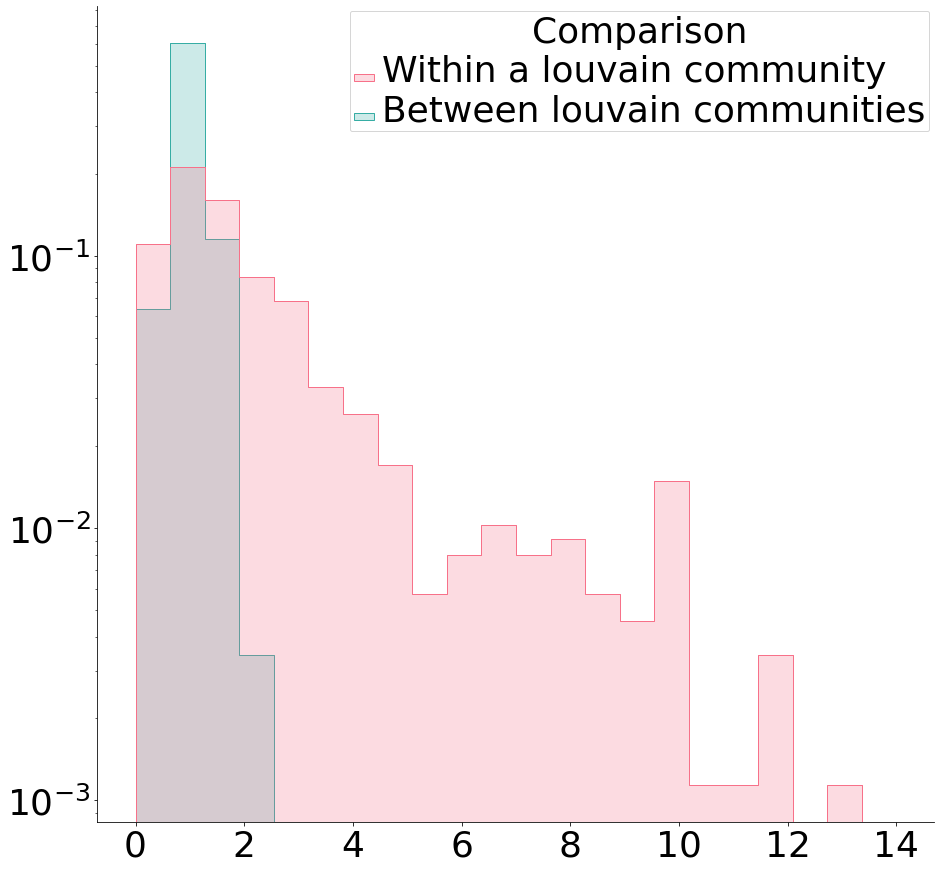

In [18]:
import seaborn as sns

tot_communities_resnik = {**fine_grained_communities_resnik,**middle_communities_resnik, **broad_communities_resnik}

avg_resnik_in_louvain=[]
avg_resnik_out_louvain=[]

for com,res_list in tot_communities_resnik.items():
    avg_resnik_in_louvain.append(float(res_list[0]))
    avg_resnik_out_louvain.append(float(res_list[1]))

state_resnik=[]
for i in avg_resnik_in_louvain:
    state_resnik.append("Within a louvain community")
for i in avg_resnik_out_louvain:
    state_resnik.append("Between louvain communities")


tot_com_resnik_in_out_df=pd.DataFrame()

tot_com_resnik_in_out_df['Resnik']=avg_resnik_in_louvain+avg_resnik_out_louvain

tot_com_resnik_in_out_df['Comparison']=state_resnik


fig, ax = plt.subplots(figsize=(15,15))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
#plt.xlabel('Resnik',fontsize=18)
#plt.ylabel('Frequency', fontsize=18)

#plt.title('Resnik distribution of total genes in each hierarchical level of clustering of EEN', fontsize=28)
g=sns.histplot(
    tot_com_resnik_in_out_df, x="Resnik", hue="Comparison", element="step",palette='husl',
    stat="density",bins=22,binrange=(0,14)
)
plt.xticks(fontsize=36) 
plt.yticks(fontsize=36) 

g.set(xlabel=None)
g.set(ylabel=None)
g.set(yscale="log")
plt.setp(ax.get_legend().get_texts(), fontsize='36') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='36') # for legend title
#plt.savefig('output/Figures/Fig2F.pdf',format='pdf',dpi=300, bbox_inches = "tight", transparent=True)


In [19]:
from scipy import stats



t_value,p_value=stats.ttest_ind(avg_resnik_in_louvain,avg_resnik_out_louvain)

p_value

3.448235156427338e-40

In [11]:
def calculate_ttest_and_effect_size(list1, list2):
    from scipy import stats
    import numpy as np
    t_value, p_value = stats.ttest_ind(list1, list2)

    n1 = len(list1)
    n2 = len(list2)
    dof = n1 + n2 - 2

    mean1 = np.mean(list1)
    mean2 = np.mean(list2)
    var1 = np.var(list1, ddof=1)
    var2 = np.var(list2, ddof=1)

    pooled_var = ((n1 - 1) * var1 + (n2 - 1) * var2) / dof
    effect_size = (mean1 - mean2) / np.sqrt(pooled_var)

    return t_value, p_value, effect_size

calculate_ttest_and_effect_size(avg_resnik_in_louvain,avg_resnik_out_louvain)

(9.08093644883574, 6.524278574858048e-19, 0.6007413610521137)

In [20]:

finegrained_avg_resnik_in_out_ratio_louvain=[]
middle_avg_resnik_in_out_ratio_louvain=[]
broad_avg_resnik_in_out_ratio_louvain=[]
state_resnik=[]

for com,res_list in fine_grained_communities_resnik.items():
    finegrained_avg_resnik_in_out_ratio_louvain.append(float(res_list[0]))
    state_resnik.append("Fine-grained")
    
for com,res_list in middle_communities_resnik.items():
    middle_avg_resnik_in_out_ratio_louvain.append(float(res_list[0]))
    state_resnik.append("Intermediate")

for com,res_list in broad_communities_resnik.items():
    broad_avg_resnik_in_out_ratio_louvain.append(float(res_list[0]))
    state_resnik.append("Broad")
    


tot_com_resnik_in_out_df=pd.DataFrame()

tot_com_resnik_in_out_df['Resnik']=finegrained_avg_resnik_in_out_ratio_louvain+middle_avg_resnik_in_out_ratio_louvain +broad_avg_resnik_in_out_ratio_louvain

tot_com_resnik_in_out_df['Comparison']=state_resnik


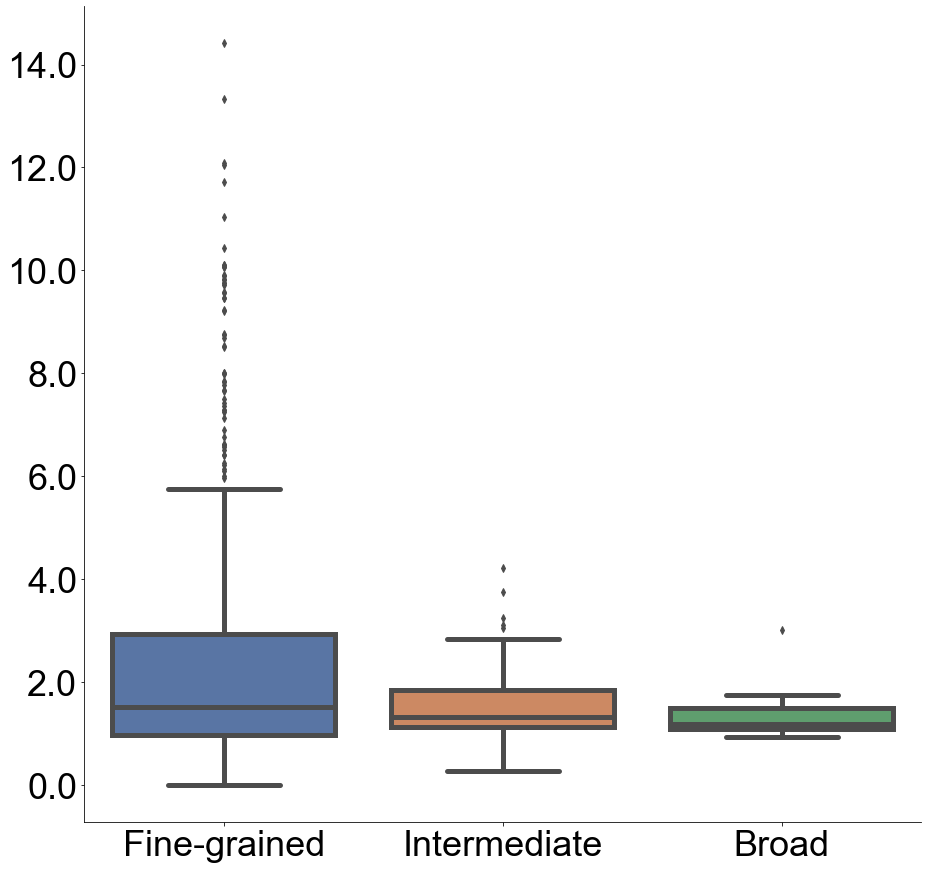

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 15))
sns.set(style="white")

g=sns.boxplot(x=tot_com_resnik_in_out_df["Comparison"], y=tot_com_resnik_in_out_df["Resnik"], linewidth=5)
#ax = sns.barplot(x="louvain Iteration", y="z-score lcc", data=EEN_louvain_com_df,
#                 palette="Blues_d")
#g.set_yscale("log")
#ax.set_xlabel("Louvain iteration",fontsize=32)
#ax.set_ylabel("lcc z-score enriched terms",fontsize=32)
ax.set_xlabel("",fontsize=32)
ax.set_ylabel("",fontsize=32)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.set_yticklabels(ax.get_yticks(), size = 36)
labels = ["Fine-grained", "Intermediate", "Broad"]  # Modified labels
ax.set_xticklabels(labels, size=36)
#plt.savefig('output/Figures/SF6D.pdf',format='pdf',dpi=300, bbox_inches = "tight")
plt.show()

In [16]:
from scipy import stats



t_value,p_value=stats.ttest_ind(finegrained_avg_resnik_in_out_ratio_louvain,middle_avg_resnik_in_out_ratio_louvain)

p_value

0.029390530403999266

In [17]:
from scipy import stats



t_value,p_value=stats.ttest_ind(finegrained_avg_resnik_in_out_ratio_louvain,broad_avg_resnik_in_out_ratio_louvain)

p_value

0.2139423794033745

In [22]:

def calculate_density_LSD(network, group):

    # Create a subnetwork of the total network
    G_subgraph = network.subgraph(group)

    # Calculate the density of that subnetwork
    density = nx.density(G_subgraph)

    return density

In [19]:
for com,explist in broad_communities_dict.items():
    print("%s:%s"%(com,calculate_density_LSD(backbone_ss_exposure_network,explist)))

10:0.038028169014084505
8:0.0196421950315165
13:0.05488770850806076
4:0.029067936459947343
11:0.045422263393546394
9:0.049801490562095145
16:0.27439227439227437
12:0.10582627481910771
14:0.0512521840419336


In [23]:
tot_com_dict={**fine_grained_communities_dict,**middle_communities_dict, **broad_communities_dict}


tot_com_resnik_in_out_list=[]
density_com_list=[]
for com,res_list in tot_communities_resnik.items():
    tot_com_resnik_in_out_list.append(res_list[0]/res_list[1])
    density_com_list.append(calculate_density_LSD(backbone_ss_exposure_network,tot_com_dict[com]))

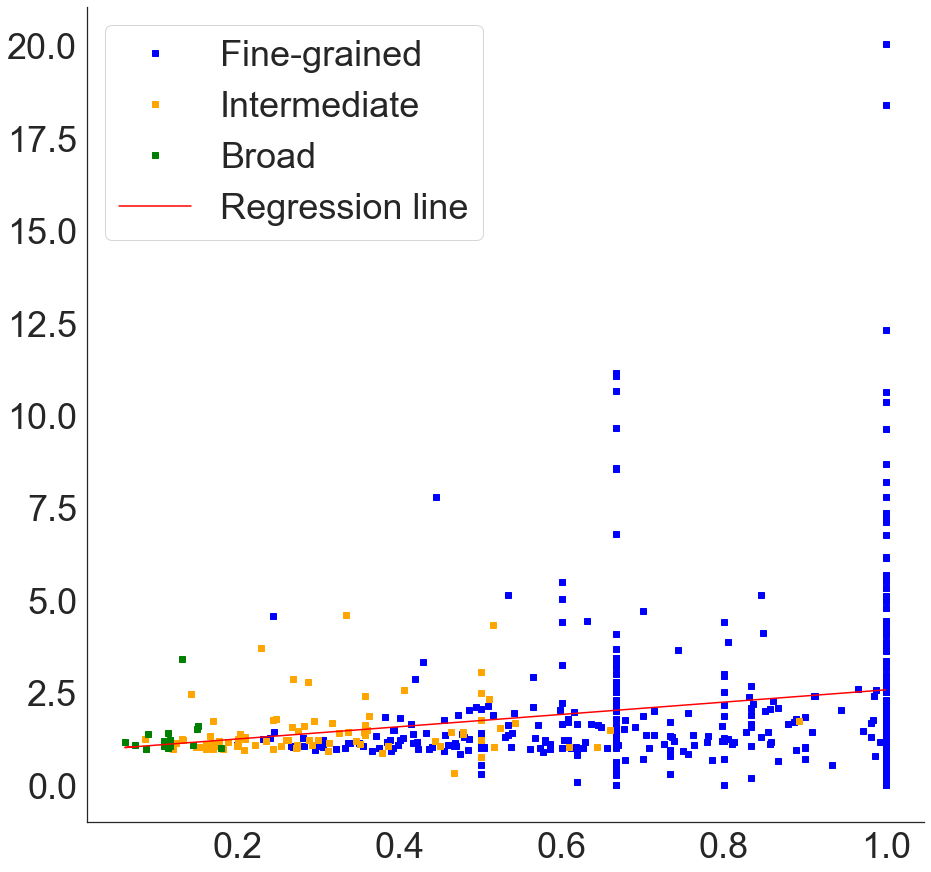

In [26]:
#Let's remove duplets
import scipy
from matplotlib.pyplot import figure
from scipy import stats

density_com_list=[]
tot_com_resnik_in_out_list=[]

fine_grained_resnik_in_out_list=[]
fine_grained_density_com_list=[]
for com,res_list in tot_communities_resnik.items():
    if com in fine_grained_communities_dict.keys():
        if len(fine_grained_communities_dict[com])>2:
            fine_grained_resnik_in_out_list.append(res_list[0]/res_list[1])
            fine_grained_density_com_list.append(calculate_density_LSD(backbone_ss_exposure_network,fine_grained_communities_dict[com]))
            tot_com_resnik_in_out_list.append(res_list[0]/res_list[1])
            density_com_list.append(calculate_density_LSD(backbone_ss_exposure_network,fine_grained_communities_dict[com]))

middle_resnik_in_out_list=[]
middle_density_com_list=[]
for com,res_list in tot_communities_resnik.items():
    if com in middle_communities_dict.keys():
        if len(middle_communities_dict[com])>2:
            middle_resnik_in_out_list.append(res_list[0]/res_list[1])
            middle_density_com_list.append(calculate_density_LSD(backbone_ss_exposure_network,middle_communities_dict[com])) 
            tot_com_resnik_in_out_list.append(res_list[0]/res_list[1])
            density_com_list.append(calculate_density_LSD(backbone_ss_exposure_network,middle_communities_dict[com])) 
    
broad_resnik_in_out_list=[]
broad_density_com_list=[]
for com,res_list in tot_communities_resnik.items():
    if com in broad_communities_dict.keys():
        if len(broad_communities_dict[com])>2:
            broad_resnik_in_out_list.append(res_list[0]/res_list[1])
            broad_density_com_list.append(calculate_density_LSD(backbone_ss_exposure_network,broad_communities_dict[com])) 
            tot_com_resnik_in_out_list.append(res_list[0]/res_list[1])
            density_com_list.append(calculate_density_LSD(backbone_ss_exposure_network,broad_communities_dict[com])) 
    
fig, ax = plt.subplots(figsize=(15,15))
slope, intercept, r, p, stderr = scipy.stats.linregress(density_com_list, tot_com_resnik_in_out_list)

ax.plot(fine_grained_density_com_list,fine_grained_resnik_in_out_list, linewidth=0, marker='s',c='blue', label='Fine-grained')
ax.plot(middle_density_com_list,middle_resnik_in_out_list, linewidth=0, marker='s',c='orange', label='Intermediate')
ax.plot(broad_density_com_list,broad_resnik_in_out_list, linewidth=0, marker='s',c='green', label='Broad')

y=[]
for i in density_com_list:
    g=(intercept + slope * i)
    y.append(g)
line = "Regression line" 

ax.plot(density_com_list, y,c='red', label=line)
#ax.set_xlabel('Average biological similarity', fontsize=18)
#ax.set_ylabel('Average chemical similarity',fontsize=18)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
plt.xticks(fontsize=36) 
plt.yticks(fontsize=36) 

# plt.title('Correlation between Resnik and Genetic overlap in %s' %met )
ax.legend(facecolor='white',fontsize=36)
#plt.savefig('output/Figures/SF5B.pdf',format='pdf',dpi=300, bbox_inches = "tight")
plt.show()

In [195]:
print(scipy.stats.pearsonr(density_com_list,tot_com_resnik_in_out_list))  # Pearson's r
print(scipy.stats.spearmanr(density_com_list,tot_com_resnik_in_out_list)) # Spearman's rho

PearsonRResult(statistic=0.2871046160686716, pvalue=1.8910934399671098e-07)
SignificanceResult(statistic=0.2557241593167573, pvalue=3.850553802687098e-06)


In [207]:

fine_grained_density_com_dict={}
for com,explist in fine_grained_communities_dict.items():
    if len(explist)>2:
        fine_grained_density_com_dict[com]=calculate_density_LSD(backbone_ss_exposure_network,explist)

middle_density_com_dict={}
for com,explist in middle_communities_dict.items():
    if len(explist)>2:
        middle_density_com_dict[com]=calculate_density_LSD(backbone_ss_exposure_network,explist)

broad_density_com_dict={}
for com,explist in broad_communities_dict.items():
    if len(explist)>2:
        broad_density_com_dict[com]=calculate_density_LSD(backbone_ss_exposure_network,explist)

   
with open('output/Communities/Louvain/fine_grained_density_com_dict.pickle', 'wb') as handle:
    pk.dump(fine_grained_density_com_dict, handle, protocol=pk.HIGHEST_PROTOCOL)
    
with open('output/Communities/Louvain/middle_density_com_dict.pickle', 'wb') as handle:
    pk.dump(middle_density_com_dict, handle, protocol=pk.HIGHEST_PROTOCOL)
    
with open('output/Communities/Louvain/broad_density_com_dict.pickle', 'wb') as handle:
    pk.dump(broad_density_com_dict, handle, protocol=pk.HIGHEST_PROTOCOL)

In [27]:
#Here, we are evaluating the resnik score across exposures for the finest level of hierarchy in louvain
#distinguishing the exposures that are part of the same community and those ones that are not part
fine_grained_communities_overlap={}

for com,exp_list in fine_grained_communities_dict.items():
    try:
        if len(exp_list)>1:
            overlap_list_in=[]
            overlap_list_out=[]
            pairwise_list = list(it.combinations(exp_list, 2))
            for i in range(len(pairwise_list)):
                try:
                    try:
                        overlap_list_in.append(tot_overlap[pairwise_list[i][0],pairwise_list[i][1]])
                    except:
                        overlap_list_in.append(tot_overlap[pairwise_list[i][1],pairwise_list[i][0]])
                except:
                    pass
            not_exp_com_list=[]
            for exp in backbone_ss_exposure_network.nodes():
                if exp not in exp_list:
                    not_exp_com_list.append(exp)
                else:
                    pass
            for exp1 in exp_list:
                for exp2 in not_exp_com_list:
                    try:
                        try:
                            overlap_list_out.append(tot_overlap[exp1,exp2])
                        except:
                            overlap_list_out.append(tot_overlap[exp2,exp1])
                    except:
                        pass
            avg_overlap_in=sum(overlap_list_in)/len(overlap_list_in)
            avg_overlap_out=sum(overlap_list_out)/len(overlap_list_out)
            fine_grained_communities_overlap[com]=[avg_overlap_in,avg_overlap_out]
        else:
            pass
    except:
        pass


            
middle_communities_overlap={}

for com,exp_list in middle_communities_dict.items():
    try:
        if len(exp_list)>1:
            overlap_list_in=[]
            overlap_list_out=[]
            pairwise_list = list(it.combinations(exp_list, 2))
            for i in range(len(pairwise_list)):
                try:
                    try:
                        overlap_list_in.append(tot_overlap[pairwise_list[i][0],pairwise_list[i][1]])
                    except:
                        overlap_list_in.append(tot_overlap[pairwise_list[i][1],pairwise_list[i][0]])
                except:
                    pass
            not_exp_com_list=[]
            for exp in backbone_ss_exposure_network.nodes():
                if exp not in exp_list:
                    not_exp_com_list.append(exp)
                else:
                    pass
            for exp1 in exp_list:
                for exp2 in not_exp_com_list:
                    try:
                        try:
                            overlap_list_out.append(tot_overlap[exp1,exp2])
                        except:
                            overlap_list_out.append(tot_overlap[exp2,exp1])
                    except:
                        pass
            avg_overlap_in=sum(overlap_list_in)/len(overlap_list_in)
            avg_overlap_out=sum(overlap_list_out)/len(overlap_list_out)
            middle_communities_overlap[com]=[avg_overlap_in,avg_overlap_out]
        else:
            pass
    except:
        pass


broad_communities_overlap={}

for com,exp_list in broad_communities_dict.items():
    try:
        if len(exp_list)>1:
            overlap_list_in=[]
            overlap_list_out=[]
            pairwise_list = list(it.combinations(exp_list, 2))
            for i in range(len(pairwise_list)):
                try:
                    try:
                        overlap_list_in.append(tot_overlap[pairwise_list[i][0],pairwise_list[i][1]])
                    except:
                        overlap_list_in.append(tot_overlap[pairwise_list[i][1],pairwise_list[i][0]])
                except:
                    pass
            not_exp_com_list=[]
            for exp in backbone_ss_exposure_network.nodes():
                if exp not in exp_list:
                    not_exp_com_list.append(exp)
                else:
                    pass
            for exp1 in exp_list:
                for exp2 in not_exp_com_list:
                    try:
                        try:
                            overlap_list_out.append(tot_overlap[exp1,exp2])
                        except:
                            overlap_list_out.append(tot_overlap[exp2,exp1])
                    except:
                        pass
            avg_overlap_in=sum(overlap_list_in)/len(overlap_list_in)
            avg_overlap_out=sum(overlap_list_out)/len(overlap_list_out)
            broad_communities_overlap[com]=[avg_overlap_in,avg_overlap_out]
        else:
            pass
    except:
        pass


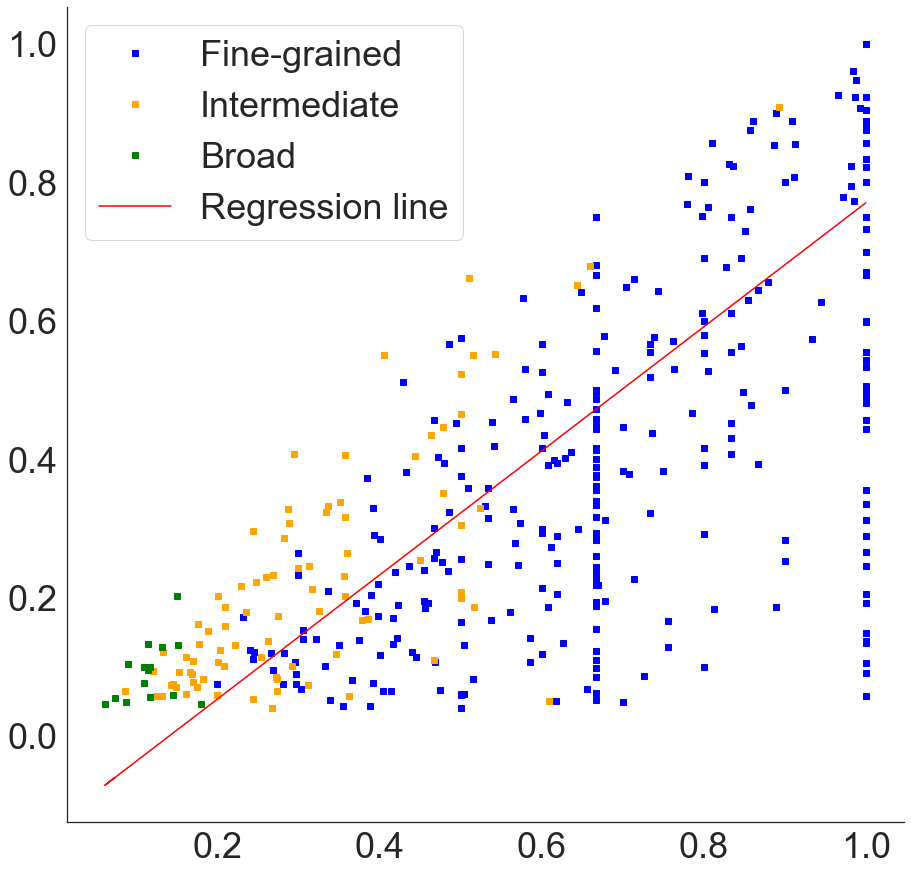

In [28]:
#Let's remove duplets and let's look at network modularity and genetic overlap
import scipy
from matplotlib.pyplot import figure
from scipy import stats

tot_communities_overlap={**fine_grained_communities_overlap,**middle_communities_overlap,**broad_communities_overlap}
density_com_list=[]
tot_com_overlap_in_list=[]

fine_grained_overlap_in_list=[]
fine_grained_density_com_list=[]
for com,res_list in tot_communities_overlap.items():
    if com in fine_grained_communities_dict.keys():
        if len(fine_grained_communities_dict[com])>2:
            fine_grained_overlap_in_list.append(res_list[0])
            fine_grained_density_com_list.append(calculate_density_LSD(backbone_ss_exposure_network,fine_grained_communities_dict[com]))
            tot_com_overlap_in_list.append(res_list[0])
            density_com_list.append(calculate_density_LSD(backbone_ss_exposure_network,fine_grained_communities_dict[com]))


middle_overlap_in_list=[]
middle_density_com_list=[]
for com,res_list in tot_communities_overlap.items():
    if com in middle_communities_dict.keys():
        if len(middle_communities_dict[com])>2:
            middle_overlap_in_list.append(res_list[0])
            middle_density_com_list.append(calculate_density_LSD(backbone_ss_exposure_network,middle_communities_dict[com])) 
            tot_com_overlap_in_list.append(res_list[0])
            density_com_list.append(calculate_density_LSD(backbone_ss_exposure_network,middle_communities_dict[com])) 
    
    
broad_overlap_in_list=[]
broad_density_com_list=[]
for com,res_list in tot_communities_overlap.items():
    if com in broad_communities_dict.keys():
        if len(broad_communities_dict[com])>2:
            broad_overlap_in_list.append(res_list[0])
            broad_density_com_list.append(calculate_density_LSD(backbone_ss_exposure_network,broad_communities_dict[com])) 
            tot_com_overlap_in_list.append(res_list[0])
            density_com_list.append(calculate_density_LSD(backbone_ss_exposure_network,broad_communities_dict[com])) 
    
fig, ax = plt.subplots(figsize=(15,15))
slope, intercept, r, p, stderr = scipy.stats.linregress(density_com_list, tot_com_overlap_in_list)

ax.plot(fine_grained_density_com_list,fine_grained_overlap_in_list, linewidth=0, marker='s',c='blue', label='Fine-grained')
ax.plot(middle_density_com_list,middle_overlap_in_list, linewidth=0, marker='s',c='orange', label='Intermediate')
ax.plot(broad_density_com_list,broad_overlap_in_list, linewidth=0, marker='s',c='green', label='Broad')

y=[]
for i in density_com_list:
    g=(intercept + slope * i)
    y.append(g)
line = "Regression line" 

ax.plot(density_com_list, y,c='red', label=line)
#ax.set_xlabel('Average biological similarity', fontsize=18)
#ax.set_ylabel('Average chemical similarity',fontsize=18)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
plt.xticks(fontsize=36) 
plt.yticks(fontsize=36) 

# plt.title('Correlation between Resnik and Genetic overlap in %s' %met )
ax.legend(facecolor='white',fontsize=36)
#plt.savefig('output/Figures/Fig2C.pdf',format='pdf',dpi=300, bbox_inches = "tight")
plt.show()

In [216]:
print(scipy.stats.pearsonr(density_com_list, tot_com_overlap_in_list))

PearsonRResult(statistic=0.7326146665534737, pvalue=9.735496667228502e-55)


In [29]:
import scipy
from matplotlib.pyplot import figure
from scipy import stats
#Let's create two lists that will containing the genetic overlap and the resnik values for these communities

avg_overlap_in_com=[]
avg_resnik_in_com=[]
for com,overlap_list in tot_communities_overlap.items():
    avg_overlap_in_com.append(overlap_list[0])
    avg_resnik_in_com.append(tot_communities_resnik[com][0])

column_names = ["Resnik", "Overlap",'Group']

geneoverlap_resnik_df = pd.DataFrame(columns = column_names)
geneoverlap_resnik_df['Resnik']=avg_resnik_in_com
geneoverlap_resnik_df['Overlap']=avg_overlap_in_com


geneoverlap_resnik_df_sort_by_overlap=geneoverlap_resnik_df.sort_values("Overlap")

cat_list=[]
for i in range(len(geneoverlap_resnik_df_sort_by_overlap)):
    if i<len(geneoverlap_resnik_df_sort_by_overlap)/5:
        cat_list.append("1st quintile")
    elif i>len(geneoverlap_resnik_df_sort_by_overlap)/5 and i<2*len(geneoverlap_resnik_df_sort_by_overlap)/5:
        cat_list.append("2nd quintile")
    elif i>2*len(geneoverlap_resnik_df_sort_by_overlap)/5 and i<3*len(geneoverlap_resnik_df_sort_by_overlap)/5:
        cat_list.append("3rd quintile")
    elif i>3*len(geneoverlap_resnik_df_sort_by_overlap)/5 and i<4*len(geneoverlap_resnik_df_sort_by_overlap)/5:
        cat_list.append("4th quintile")
    else:
        cat_list.append("5th quintile")
        
geneoverlap_resnik_df_sort_by_overlap["Group"]=cat_list

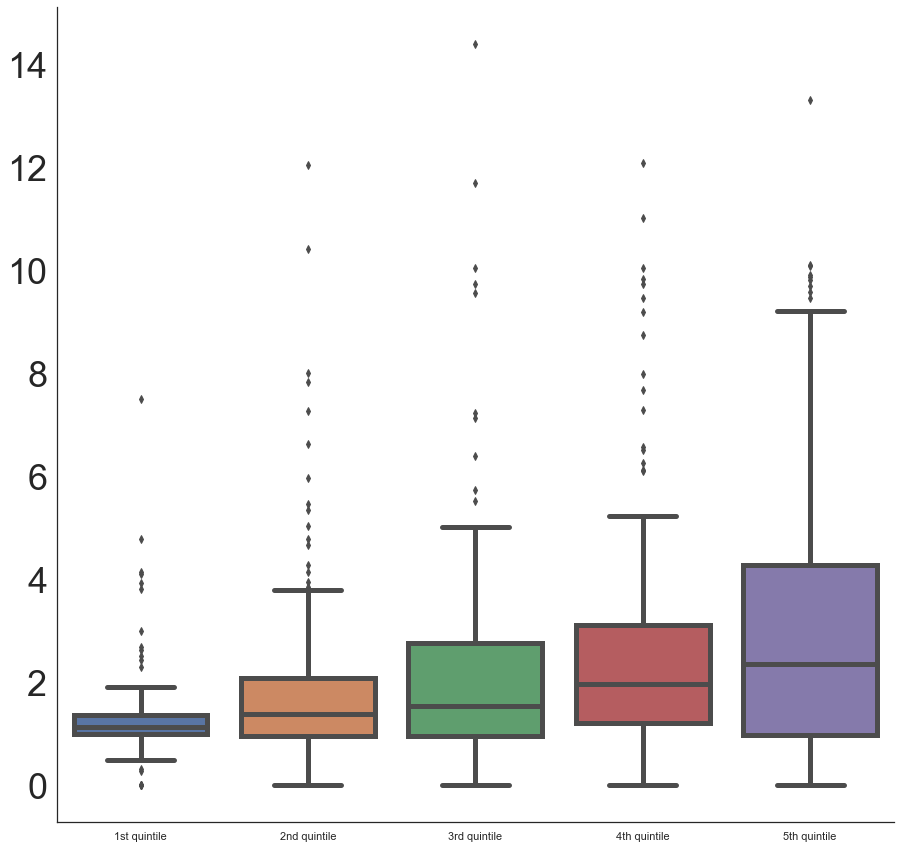

In [30]:
#Let's visualize as boxplot
import seaborn as sns
import matplotlib.pyplot as plt

# set a grey background (use sns.set_theme() if seaborn version 0.11.0 or above) 
fig, ax = plt.subplots(figsize=(15, 15))

sns.set_style('white')
sns.set(style="white",font_scale = 2)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
g=sns.boxplot(data=geneoverlap_resnik_df_sort_by_overlap,x="Group", y="Resnik",order=['1st quintile','2nd quintile', '3rd quintile','4th quintile',
 '5th quintile'],linewidth=5)
plt.xlabel('',fontsize=22)
plt.ylabel('', fontsize=22)
#plt.xticks([], fontsize=22)
ax.grid(False)
ax.set_yticklabels([int(i) for i in ax.get_yticks()], size = 36)
#ax.set_xticklabels(ax.get_xticks(), size = 36)
#plt.savefig('output/Figures/SF6E.pdf',format='pdf',dpi=300, bbox_inches = "tight")
#g.set_yscale("log")

plt.show()
